##Library Import

In [1]:
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

##Data Preprocessing

In [2]:
df = pd.read_csv('/content/drive/MyDrive/UTS/Hass-DSI/Device Data/Device Data (Updated)/ssd_05500B.csv')
df.head()

,Unnamed: 0,ts,p,t,h,als,uv,voc,pm1,pm25,pm10,People Count,sensorid
0,0,2022-10-06 17:00:00,1020.325000,20.929000,53.590000,103.0,0.0,0.500000,0.0,0.000000,0.000000,26.0,05500B
1,1,2022-10-06 17:30:00,1020.274000,21.725000,51.485000,49.0,0.0,0.500000,0.0,0.000000,0.000000,16.0,05500B
2,2,2022-10-06 18:00:00,1020.331000,21.814000,50.621000,49.5,0.0,0.505000,0.0,0.004000,0.024000,17.0,05500B
3,3,2022-10-06 18:30:00,1020.530000,21.549167,50.298333,50.0,0.0,0.518333,0.0,0.000000,0.024167,18.0,05500B
4,4,2022-10-06 19:00:00,1020.864545,21.553636,51.285455,50.0,0.0,0.598182,0.0,0.017273,0.017273,15.0,05500B


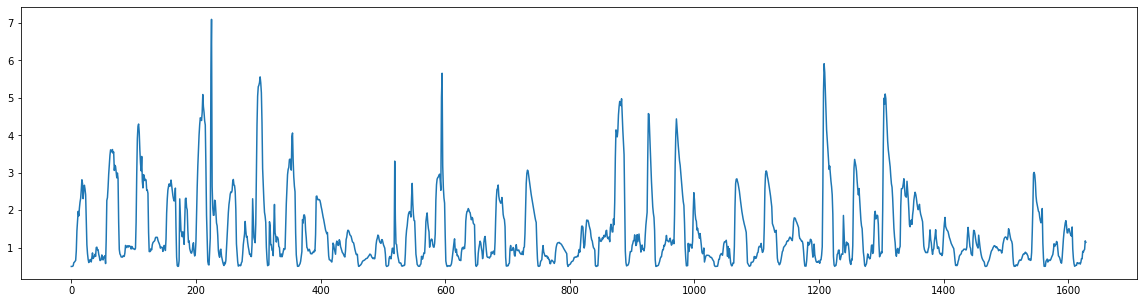

In [3]:
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(df['voc'])

##Results

###ADF Test (Stationary Test)

In [4]:
ADF_result = adfuller(df['voc'])

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -11.055852353268808
p-value: 4.947267017409293e-20


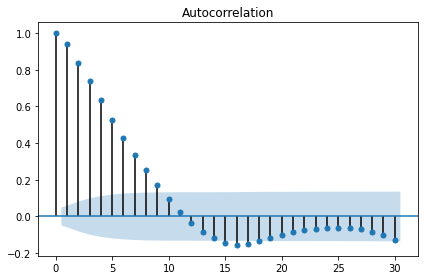

In [5]:
plot_acf(df['voc'], lags=30);

plt.tight_layout()

###Forecasting

In [6]:
df_voc = pd.DataFrame({'voc': df['voc']})

train = df_voc[:int(0.9*len(df_voc))]
test = df_voc[int(0.9*len(df_voc)):]

print(len(train))
print(len(test))

1466
163


In [57]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))

        return pred_mean

    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'MA':
        pred_MA = []
        
        for i in range(train_len, total_len, window):
          model = SARIMAX(np.array(df_voc[:i]).reshape(1,-1)[0], order=(0,0,9))
          res = model.fit(disp=False)
          predictions = res.get_prediction(i, i+window-1)
          oos_pred = predictions.predicted_mean
          pred_MA = np.append(pred_MA,oos_pred)
            
        return pred_MA

In [81]:
pred_df = test.copy()

TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 5

#pred_MA = rolling_forecast(df_voc, TRAIN_LEN, HORIZON, WINDOW, 'MA')

pred_df['Rolling Average'] = pred_df['voc'].rolling(WINDOW, min_periods=1).mean()
pred_df['pred_MA'] = pred_MA[:-2]

pred_df.head()

,voc,Rolling Average,pred_MA
1466,0.515385,0.515385,0.580169
1467,0.500000,0.507692,0.541888
1468,0.502000,0.505795,0.434830
1469,0.510667,0.507013,0.318327
1470,0.548649,0.515340,0.198476


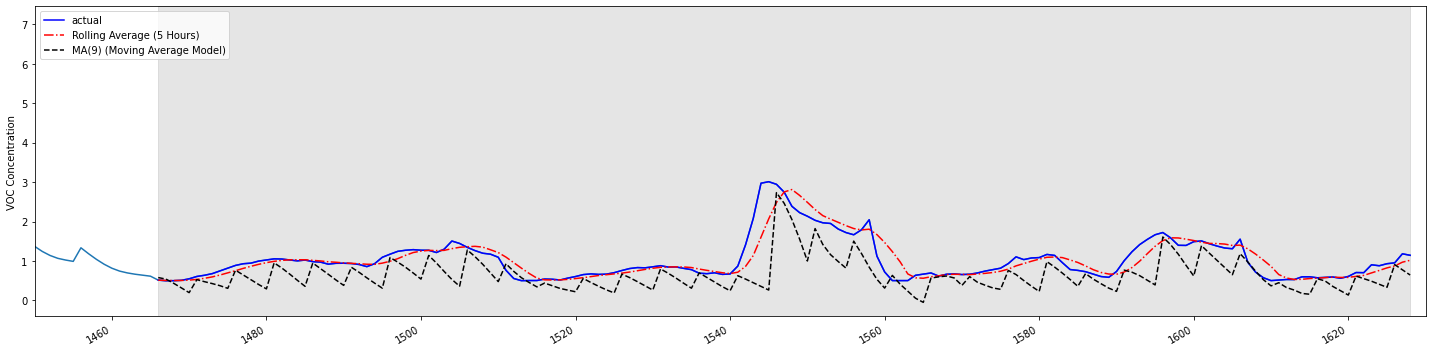

In [82]:
fig, ax = plt.subplots(figsize=(20,5))

ax.plot(df_voc)
ax.plot(pred_df['voc'], 'b-', label='actual')
ax.plot(pred_df['Rolling Average'], 'r-.', label=f'Rolling Average ({WINDOW} Hours)')
ax.plot(pred_df['pred_MA'], 'k--', label='MA(9) (Moving Average Model)')

ax.legend(loc=2)

#ax.set_xlabel('Time')
ax.set_ylabel('VOC Concentration')

ax.axvspan(1466, 1628, color='#808080', alpha=0.2)

ax.set_xlim(1450, 1630)

fig.autofmt_xdate()
plt.tight_layout()

In [83]:
from sklearn.metrics import mean_squared_error

mse_last = mean_squared_error(pred_df['voc'], pred_df['Rolling Average'])
mse_MA = mean_squared_error(pred_df['voc'], pred_df['pred_MA'])

print(mse_last, mse_MA)

0.05726059449303855 0.29477131732134176


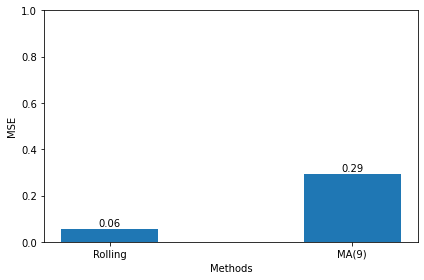

In [84]:
fig, ax = plt.subplots()

x = ['Rolling', 'MA(9)']
y = [mse_last, mse_MA]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Methods')
ax.set_ylabel('MSE')
ax.set_ylim(0, 1)

for index, value in enumerate(y):
    plt.text(x=index, y=value+0.01, s=str(round(value, 2)), ha='center')

plt.tight_layout()

In [85]:
df['pred_voc'] = pd.Series()
df['pred_voc'][1466:] = df['voc'].iloc[1466] + pred_df['pred_MA']

<ipython-input-85-53e1065695dc>:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df['pred_voc'] = pd.Series()
<ipython-input-85-53e1065695dc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred_voc'][1466:] = df['voc'].iloc[1466] + pred_df['pred_MA']


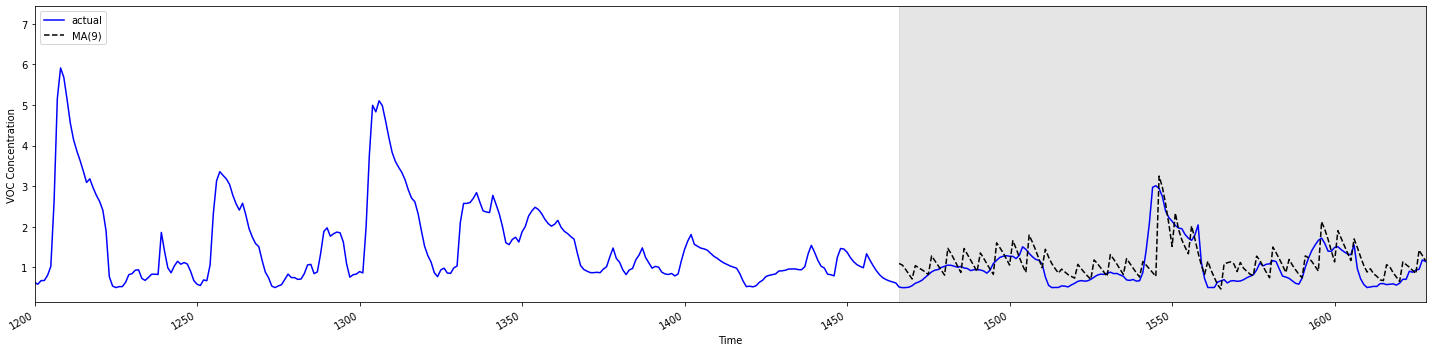

In [86]:
fig, ax = plt.subplots(figsize=(20,5))

ax.plot(df['voc'], 'b-', label='actual')
ax.plot(df['pred_voc'], 'k--', label='MA(9)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('VOC Concentration')

ax.axvspan(1466, 1628, color='#808080', alpha=0.2)

ax.set_xlim(1200, 1628)

fig.autofmt_xdate()
plt.tight_layout()